In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt 
import sklearn
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision
from torchvision import transforms
import inspect
import scipy
from scipy.stats import entropy

In [148]:
config = {"input_size" : 784,
          "hidden_layer1" : 512,
          "hidden_layer2" : 256,
          "bottleneck" : 128,
          "hidden_layer3" : 256,
          "hidden_layer4" : 512,
          "learning_rate" : 0.001,
          "number_epoch" : 100,
          "batch_size" : 100,
          "eps": 1e-12
          }

In [3]:
transformation = transforms.Compose([transforms.ToTensor()])

In [4]:
train_dataset = torchvision.datasets.MNIST(root='./data', train=True, transform=transformation, download=True)
test_dataset = torchvision.datasets.MNIST(root='./data', train=False, transform=transformation, download=True)

train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=config["batch_size"], shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=config["batch_size"], shuffle=False)

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 9.91M/9.91M [00:00<00:00, 12.5MB/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 28.9k/28.9k [00:00<00:00, 333kB/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 1.65M/1.65M [00:00<00:00, 3.24MB/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 4.54k/4.54k [00:00<00:00, 5.41MB/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [391]:
import scipy.stats


class VariationalAutoencoder(nn.Module):
    def __init__(self, input_size=config["input_size"], hidden_layer1=config["hidden_layer1"], hidden_layer2=config["hidden_layer2"], bottleneck=config["bottleneck"], hidden_layer3=config["hidden_layer3"], hidden_layer4=config["hidden_layer4"]):
        super(VariationalAutoencoder, self).__init__()

        self.encoding_layers = nn.Sequential(
            nn.Linear(input_size, hidden_layer1),
            nn.LeakyReLU(),
            nn.Linear(hidden_layer1, hidden_layer2),
            nn.LeakyReLU(),
            nn.Linear(hidden_layer2, bottleneck)
        )

        self.mew = nn.Linear(bottleneck, 1)
        self.sigma = nn.Linear(bottleneck, 1)

        self.decoding_layers = nn.Sequential(
            nn.Linear(bottleneck, hidden_layer3),
            nn.LeakyReLU(),
            nn.Linear(hidden_layer3, hidden_layer4),
            nn.LeakyReLU(),
            nn.Linear(hidden_layer4, input_size),
            nn.Sigmoid()
        )  
    def encoder_forward(self, data_vector):
        # make some error handling here later hopefully 
        # q_phi(z|x) is what we want to calculate here, we assume q_phi(z|x) is a from a normal
        # we must find mew and sigma^2 for the normal 
        # to find the following we take the data vector and put in its latent representation  
        # q_phi(z|x) is approximatly N_phi(z|x) with paramters mew and sigma as phi

        encoder_output = self.encoding_layers(data_vector)
        mew = self.mew(encoder_output)
        sigma = self.sigma(encoder_output)

        return mew, sigma

    def decoder_forward(self, mew, sigma):
        #z = u + sigma * eita^i
        #eita ~ N(0, 1)
        # 100 by 128



        eps = torch.randn((config['batch_size'], config['bottleneck']))


        z = mew + sigma * eps
       
        
        decoder_output = self.decoding_layers(z)

        return decoder_output


In [392]:
def Elbo(data_vector, output_vector, mew, sigma):
    MSE = nn.MSELoss()
    L_2 = MSE(data_vector, output_vector)
    running_kl_divergence = -0.5 * (1 + torch.log(sigma**2 + config['eps']) - mew**2 - sigma**2)
    
    loss = running_kl_divergence + L_2

    return loss.mean()
    

In [398]:
Model = VariationalAutoencoder()
sig = inspect.signature(VariationalAutoencoder.__init__)
keys_list = [key for key in sig.parameters.keys() if key != 'self']
Model = VariationalAutoencoder(*[config[key] for key in keys_list])
optimizer = optim.Adam(Model.parameters(), lr=1e-3)
losses = []
new_avg_loss = 0
for epoch in range(config["number_epoch"]):
    epoch_loss = []
    for (i, (image_matrix, label) )in enumerate(train_loader):       
        #Forward pass
        image_vector = image_matrix.reshape(-1, config["input_size"])

        image_vector = image_vector.type(torch.float32)


        mew, sigma = Model.encoder_forward(image_vector)
    


        reconstructed_image = Model.decoder_forward(mew, sigma)



        loss = Elbo(image_vector, reconstructed_image, mew, sigma)
        losses.append(loss.item())
        epoch_loss.append(loss.item())
        
        #backpropogation

        optimizer.zero_grad()
        loss.backward()
        optimizer.step() 

        avg_loss = sum(epoch_loss) / len(epoch_loss)
        if i % 100 == 0:
            print(f'Epoch [{epoch+1}/{config["number_epoch"]}], Avg Loss: {avg_loss:.6f}')
            convegence_check = abs(avg_loss - new_avg_loss) / max(1, new_avg_loss)  
            print(convegence_check)
            if convegence_check < 1e-2:
                break
            new_avg_loss = avg_loss
        
  


Epoch [1/100], Avg Loss: 3.656577
3.6565773487091064
Epoch [1/100], Avg Loss: 0.190793
0.9478221074063552
Epoch [1/100], Avg Loss: 0.135626
0.05516619880656515
Epoch [1/100], Avg Loss: 0.113996
0.021630169557365728
Epoch [1/100], Avg Loss: 0.102727
0.011268775753381893
Epoch [1/100], Avg Loss: 0.095925
0.006802188796421874
Epoch [2/100], Avg Loss: 0.072343
0.030383909729650785
Epoch [2/100], Avg Loss: 0.068415
0.003928414592058352
Epoch [3/100], Avg Loss: 0.070528
0.0018152669072151184
Epoch [4/100], Avg Loss: 0.069011
0.00333210825920105
Epoch [5/100], Avg Loss: 0.067159
0.005184844136238098
Epoch [6/100], Avg Loss: 0.069408
0.002934955060482025
Epoch [7/100], Avg Loss: 0.070532
0.0018110200762748718
Epoch [8/100], Avg Loss: 0.069877
0.0024660900235176086
Epoch [9/100], Avg Loss: 0.067345
0.004998192191123962
Epoch [10/100], Avg Loss: 0.067178
0.005165062844753265
Epoch [11/100], Avg Loss: 0.067714
0.004629388451576233
Epoch [12/100], Avg Loss: 0.068039
0.004304341971874237
Epoch [13/

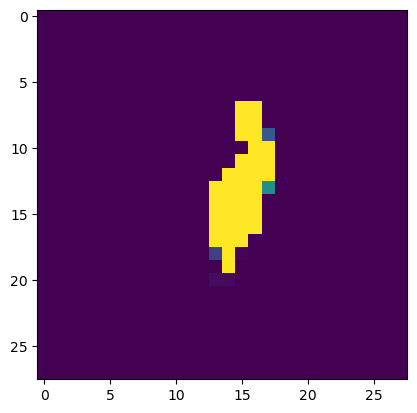

In [406]:

plt.imshow(Model.decoder_forward(50, 10)[0].view(28, 28).detach().numpy())